In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm
import numpy as np

In [ ]:
data = pd.read_csv("dataset_mood_smartphone.csv", index_col=0)              # Load the data                                                    

In [ ]:
data.tail(), data.columns

In [ ]:
# Pivot the dataset to have each variable as a column
data_pivoted = data.pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc='first').reset_index()

# Show the transformed data
data_pivoted.head()

In [ ]:
# Dataset summary
summary = {
    "Number of Records": len(data_pivoted),
    "Number of Attributes": len(data_pivoted.columns),
    "Attribute Types": data_pivoted.dtypes,
    "Missing Values": data_pivoted.isnull().sum(),
    "Range of Numeric Values": data_pivoted.describe().loc[['min', 'max']],
}

# Prepare descriptions for numeric attributes
numerical_descriptions = data_pivoted.describe()

numerical_descriptions


In [ ]:
data_pivoted.info()

In [ ]:
data_pivoted.describe()

In [ ]:
# Set up the figure layout to accommodate multiple plots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 22))
axes = axes.flatten()

# Plot histograms for each numeric column
for i, col in enumerate(data_pivoted.select_dtypes(include='float64').columns):
    sns.histplot(data_pivoted[col].dropna(), ax=axes[i], bins=30, kde=False)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("Variable_Distributions.eps", format='eps')
#plt.show()


In [ ]:
# Extract all numeric columns for histograms (excluding 'id' and 'time' which are not numeric)
numeric_vars = data_pivoted.select_dtypes(include=['float64', 'int64']).columns
# Set up the figure layout to accommodate multiple boxplots
fig, axes = plt.subplots(nrows=(len(numeric_vars) // 4 + (len(numeric_vars) % 4 > 0)), ncols=4, figsize=(18, 40))
axes = axes.flatten()

# Generate boxplots for each numeric column
for i, var in enumerate(numeric_vars):
    sns.boxplot(y=data_pivoted[var], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {var}')
    axes[i].set_ylabel(var)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("Box_plot.eps", format='eps')


#### Outlier Analysis

In [ ]:

# Function to calculate outliers using IQR
def calculate_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Calculate outliers for each variable of interest
outlier_counts = {}
outlier_percentages = {}

# List of all relevant variables including app categories
variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms',
             'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 
             'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 
             'appCat.unknown', 'appCat.utilities', 'appCat.weather']

for var in variables:
    if data_pivoted[var].dtype == 'float64' or data_pivoted[var].dtype == 'int64':
        outliers = calculate_outliers(data_pivoted[var].dropna())
        outlier_counts[var] = len(outliers)
        outlier_percentages[var] = (len(outliers) / len(data_pivoted[var].dropna())) * 100

# Create a DataFrame to summarize the outlier analysis
outlier_summary = pd.DataFrame({
    "Variable": outlier_counts.keys(),
    "Number of Outliers": outlier_counts.values(),
    "Percentage of Outliers": outlier_percentages.values()
})

outlier_summary.sort_values(by='Percentage of Outliers', ascending=False)


In [ ]:
# Calculate the type of value, range, and number of missing values for each variable
attribute_info = {
    'Variable': [],
    'Type of Value': [],
    'Range of Values': [],
    'Number of Missing Values': []
}

for var in variables:
    # Appending variable name
    attribute_info['Variable'].append(var)
    
    # Determining type of value and appending
    if data_pivoted[var].dtype == 'float64':
        attribute_info['Type of Value'].append('Numeric')
    elif data_pivoted[var].dtype == 'int64':
        attribute_info['Type of Value'].append('Integer')
    else:
        attribute_info['Type of Value'].append('Categorical')
    
    # Calculating and appending range of values for numeric variables
    if data_pivoted[var].dtype == 'float64' or data_pivoted[var].dtype == 'int64':
        min_val = data_pivoted[var].min()
        max_val = data_pivoted[var].max()
        attribute_info['Range of Values'].append(f"{min_val} to {max_val}")
    else:
        attribute_info['Range of Values'].append("N/A")
    
    # Counting and appending number of missing values
    missing_count = data_pivoted[var].isna().sum()
    attribute_info['Number of Missing Values'].append(missing_count)

# Convert to DataFrame for easier LaTeX conversion
attribute_info_df = pd.DataFrame(attribute_info)
attribute_info_df


In [ ]:
# Convert 'time' to datetime if not already done
if data_pivoted['time'].dtype == object:
    data_pivoted['time'] = pd.to_datetime(data_pivoted['time'])

# Extract date from datetime
data_pivoted['date'] = data_pivoted['time'].dt.date

# Calculate number of unique users and dates
num_unique_users = data_pivoted['id'].nunique()
num_unique_dates = data_pivoted['date'].nunique()

num_unique_users, num_unique_dates


In [ ]:
# Ensure 'time' column is of datetime type
if data_pivoted['time'].dtype != 'datetime64[ns]':
    data_pivoted['time'] = pd.to_datetime(data_pivoted['time'])

# Extract date from datetime if not already done
data_pivoted['date'] = data_pivoted['time'].dt.date

# Grouping data by 'id' and 'date'
grouped_data = data_pivoted.groupby(['id', 'date']).agg({
    'mood': 'mean',  # average mood per day per user
    'screen': 'sum',  # total screen time per day per user
    'activity': 'mean',  # average activity per day per user
    'circumplex.arousal': 'mean',  # average arousal per day per user
    'circumplex.valence': 'mean',  # average valence per day per user
    'call': 'sum',  # total number of calls per day per user
    'sms': 'sum',  # total number of SMS sent per day per user
    'appCat.builtin': 'sum',  # total usage of built-in apps per day per user
    'appCat.communication': 'sum',  # total usage of communication apps per day per user
    'appCat.entertainment': 'sum',  # total usage of entertainment apps per day per user
    'appCat.finance': 'sum',  # total usage of finance apps per day per user
    'appCat.game': 'sum',  # total usage of game apps per day per user
    'appCat.office': 'sum',  # total usage of office apps per day per user
    'appCat.other': 'sum',  # total usage of other apps per day per user
    'appCat.social': 'sum',  # total usage of social apps per day per user
    'appCat.travel': 'sum',  # total usage of travel apps per day per user
    'appCat.unknown': 'sum',  # total usage of unknown apps per day per user
    'appCat.utilities': 'sum',  # total usage of utilities apps per day per user
    'appCat.weather': 'sum'  # total usage of weather apps per day per user
    # Add other variables as needed
})

# Resetting index if you want 'id' and 'date' back as columns for further use
grouped_data.reset_index(inplace=True)


In [ ]:
grouped_data.shape

In [ ]:
# List of all relevant variables including app categories
variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms',
             'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 
             'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 
             'appCat.unknown', 'appCat.utilities', 'appCat.weather']
# Calculate the type of value, range, and number of missing values for each variable
attribute_info = {
    'Variable': [],
    'Type of Value': [],
    'Range of Values': [],
    'Number of Missing Values': []
}

for var in variables:
    # Appending variable name
    attribute_info['Variable'].append(var)
    
    # Determining type of value and appending
    if grouped_data[var].dtype == 'float64':
        attribute_info['Type of Value'].append('Numeric')
    elif grouped_data[var].dtype == 'int64':
        attribute_info['Type of Value'].append('Integer')
    else:
        attribute_info['Type of Value'].append('Categorical')
    
    # Calculating and appending range of values for numeric variables
    if grouped_data[var].dtype == 'float64' or grouped_data[var].dtype == 'int64':
        min_val = grouped_data[var].min()
        max_val = grouped_data[var].max()
        attribute_info['Range of Values'].append(f"{min_val} to {max_val}")
    else:
        attribute_info['Range of Values'].append("N/A")
    
    # Counting and appending number of missing values
    missing_count = grouped_data[var].isna().sum()
    attribute_info['Number of Missing Values'].append(missing_count)

# Convert to DataFrame for easier LaTeX conversion
attribute_info_df = pd.DataFrame(attribute_info)
attribute_info_df

In [ ]:
grouped_data.head()

In [ ]:
# Count NaNs for all variables where NaNs are straightforward missing data
nan_missing_counts = grouped_data.isna().sum()

# For sum-based variables, count zeros as missing data
sum_based_variables = [
    'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance',
    'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
    'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'screen', 'sms', 'call'
]
zero_missing_counts = (grouped_data[sum_based_variables] == 0).sum()

# Combine NaN missing counts with zero missing counts for relevant variables
total_missing_counts = nan_missing_counts.copy()
total_missing_counts.update(zero_missing_counts)

total_missing_counts


In [ ]:
 # Calculate the range (min and max values) for each variable
range_values = grouped_data.describe().loc[['min', 'max']].T
range_values

In [ ]:

# Filter to exclude non-numeric columns and columns not relevant for box plot
numeric_columns = grouped_data.select_dtypes(include=['float64', 'int64']).columns

# Set up the plot
plt.figure(figsize=(18, 12))

# Plot a box plot for each variable
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(5, 4, i)  # Adjust grid size based on the number of numeric variables
    grouped_data.boxplot(column=column, grid=False)
    plt.title(column)

plt.tight_layout()
plt.savefig("Box_plot_grouped.eps", format='eps')


In [111]:
# Columns where zeros should be considered as missing data
columns_to_consider = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 
                       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 
                       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'screen', 'call', 'sms']

# Replace zeros with NaN in the specified columns
aggregated_data_with_zeros_as_nan = grouped_data.copy()
aggregated_data_with_zeros_as_nan[columns_to_consider] = aggregated_data_with_zeros_as_nan[columns_to_consider].replace(0, np.nan)

# Calculate the new counts of missing values including zeros as NaNs for each variable for each ID
missing_including_zeros = aggregated_data_with_zeros_as_nan.groupby('id').apply(lambda x: x.isna().sum())
missing_including_zeros.head()  # Display the updated missing data summary for the first few IDs



variable,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.builtin,...,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather
id,,,,,,,,,,,,,,,,,,,,,
AS14.01,0,0,25,25,25,25,25,21,47,25,...,25,40,65,64,26,25,47,66,27,71
AS14.02,0,0,27,31,32,27,27,2,26,32,...,36,68,68,68,37,35,55,68,64,68
AS14.03,0,0,30,29,30,30,30,19,41,29,...,29,52,77,49,30,73,64,44,56,75
AS14.05,0,0,17,17,20,17,17,26,53,19,...,17,70,70,69,17,36,69,32,28,70
AS14.06,0,0,29,29,29,29,29,24,49,30,...,28,74,66,49,30,28,42,73,74,65


### Missing values Handling with median

In [112]:
aggregated_data_with_zeros_as_nan.shape

(1973, 21)

In [113]:
# Select only the numeric columns for imputation (excluding the 'id' column)
numeric_columns = aggregated_data_with_zeros_as_nan.select_dtypes(include=np.number).columns

# Loop over each ID
for id_val in aggregated_data_with_zeros_as_nan['id'].unique():
    # Calculate median for all numeric attributes for the current ID
    median_values_by_id = aggregated_data_with_zeros_as_nan.loc[aggregated_data_with_zeros_as_nan['id'] == id_val, numeric_columns].median()
    
    # Impute missing values, including zeros, with the calculated median for each attribute and each ID
    for col in numeric_columns:
        aggregated_data_with_zeros_as_nan.loc[(aggregated_data_with_zeros_as_nan['id'] == id_val) & (aggregated_data_with_zeros_as_nan[col].isna() | (aggregated_data_with_zeros_as_nan[col] == 0)), col] = median_values_by_id[col]


In [114]:
aggregated_data_with_zeros_as_nan.shape

(1973, 21)

In [115]:
data_handled_mis = aggregated_data_with_zeros_as_nan.copy()

In [116]:
data_handled_mis.shape

(1973, 21)

In [117]:
def create_lag_features(df, columns):
    """
    Create lag features for specified columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing the data.
        columns (list of str): List of column names to create lag features for.
        lags (list of int): List of lag intervals to create features at.
    
    Returns:
        pd.DataFrame: DataFrame with new lag features.
    """
    df_copy = df.copy()
    for column in columns:
        df_copy[f'{column}_lag'] = df_copy.groupby('id')[column].shift(-1)
    return df_copy


In [118]:
lagged_df = create_lag_features(data_handled_mis, data_handled_mis.columns)

In [119]:
lagged_df.shape

(1973, 42)

In [121]:
# Drop the last row of the data
lagged_df.drop(lagged_df.index[-1], inplace=True)
# Replace the name of the 'mood_lagged' column with 'target_column'
lagged_df.rename(columns={'mood_lagged': 'target_column'}, inplace=True)

In [122]:
lagged_df.tail()

variable,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.builtin,...,appCat.entertainment_lag,appCat.finance_lag,appCat.game_lag,appCat.office_lag,appCat.other_lag,appCat.social_lag,appCat.travel_lag,appCat.unknown_lag,appCat.utilities_lag,appCat.weather_lag
1967,AS14.33,2014-05-26,5.4,18925.187999,0.115201,-0.400000,0.4,10.0,3.0,1048.739,...,124.6940,3.106,NaN,244.2195,142.686,2010.3640,52.436,4.011,56.1730,NaN
1968,AS14.33,2014-05-27,6.2,4089.879001,0.012704,-0.600000,0.4,1.0,2.0,726.391,...,614.7060,3.106,NaN,357.9090,529.946,5361.2110,52.436,4.011,30.6660,NaN
1969,AS14.33,2014-05-28,8.2,14320.867998,0.103301,-0.400000,1.2,10.0,1.0,2551.046,...,136.7380,3.106,NaN,244.2195,29.202,1789.9220,0.939,4.011,3.1990,NaN
1970,AS14.33,2014-05-29,7.0,3569.341000,0.169354,-1.333333,1.0,5.0,1.0,400.034,...,260.2200,3.106,NaN,244.2195,52.610,3166.4090,1052.648,8.072,232.8250,NaN
1971,AS14.33,2014-05-30,6.8,9497.646999,0.192901,-0.800000,-0.4,4.0,1.0,3044.030,...,702.1665,3.106,NaN,244.2195,62.001,4520.2725,52.436,4.011,68.2255,NaN


### Correlation between features

Text(0.5, 1.0, 'Correlation Matrix of Attributes')

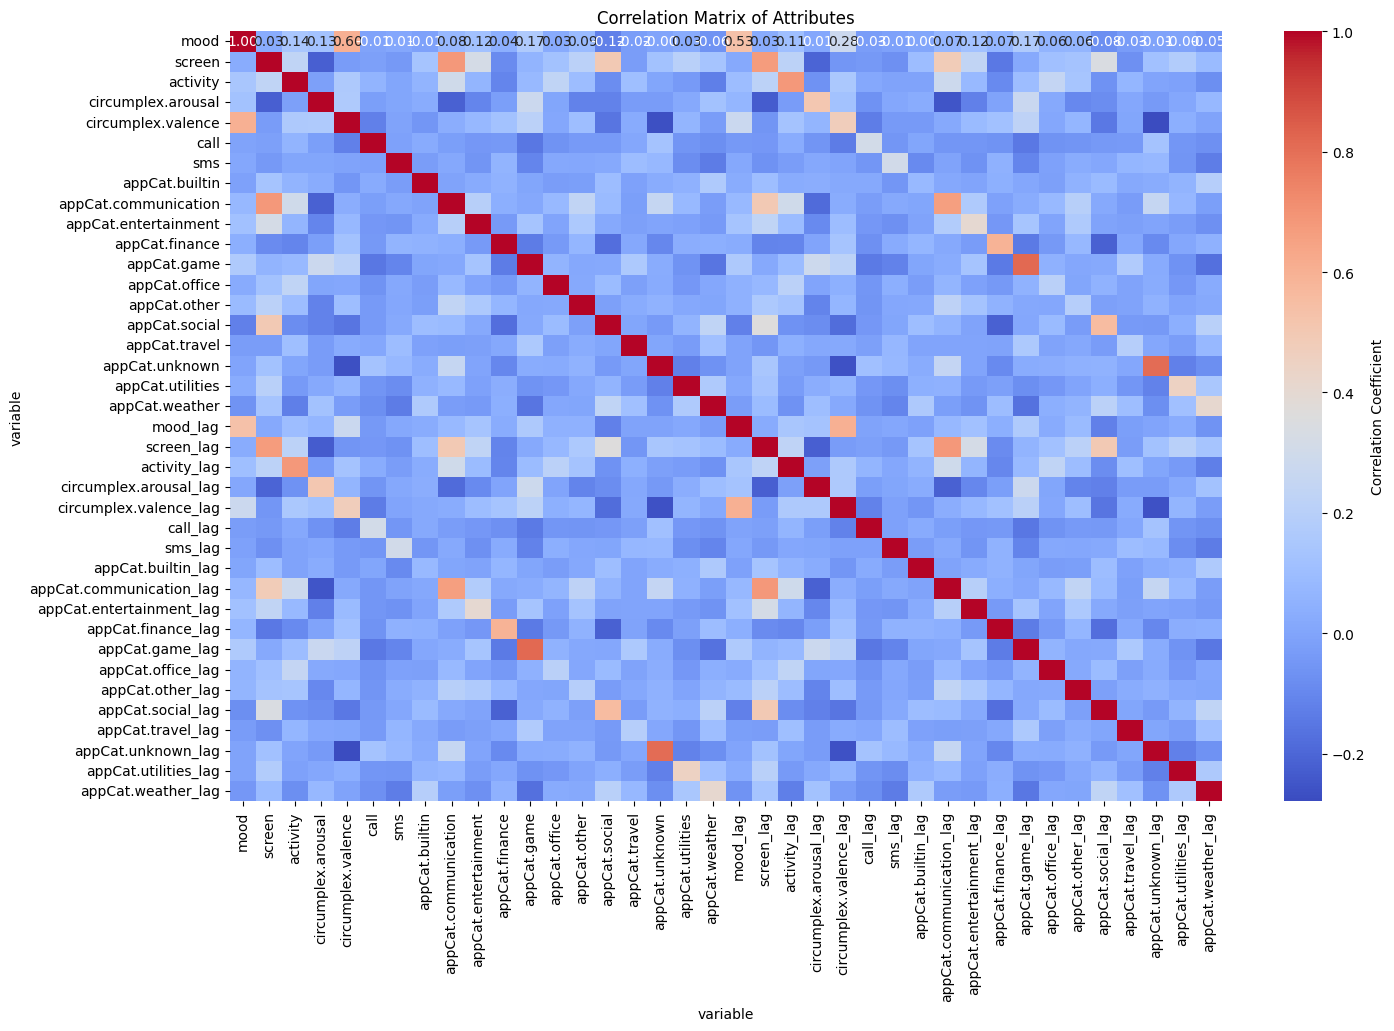

In [123]:
# Select only the numeric columns for correlation analysis (excluding the 'id' column)
numeric_columns = lagged_df.select_dtypes(include=np.number).columns

# Calculate the correlation matrix
correlation_matrix = lagged_df[numeric_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 10))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Attributes')


In [125]:
# Select only the numeric columns (excluding the 'id' column)
numeric_columns = lagged_df.select_dtypes(include=np.number).columns

# Calculate the Pearson correlation coefficients between the target column and other numeric attribute columns
pearson_correlation = lagged_df[numeric_columns].corrwith(lagged_df['mood_lag'], method='pearson').sort_values(ascending=False)

# Display the Pearson correlation coefficients
print(pearson_correlation)



variable
mood_lag                    1.000000
circumplex.valence_lag      0.602362
mood                        0.532819
circumplex.valence          0.272330
appCat.game_lag             0.169391
appCat.game                 0.164815
activity_lag                0.143403
appCat.entertainment        0.134577
circumplex.arousal_lag      0.125653
appCat.entertainment_lag    0.116168
activity                    0.099735
appCat.other_lag            0.088396
appCat.communication        0.084576
appCat.communication_lag    0.075635
circumplex.arousal          0.066903
appCat.other                0.047843
appCat.office               0.046273
appCat.finance_lag          0.038079
appCat.finance              0.029548
appCat.utilities_lag        0.028556
appCat.builtin              0.028403
appCat.office_lag           0.025442
screen_lag                  0.025340
screen                      0.019906
sms                         0.014344
appCat.utilities            0.013759
sms_lag                     0

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Split the dataset into features (X) and the target variable (y)
X = combined_data.drop(columns=['target_column', 'id'])  # Features
y = combined_data['target_column']  # Target variable

# Step 2: Split the data into training and testing sets based on time
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Step 3: Train a Random Forest model on the training data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Evaluate the model's performance on the testing data
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


In [ ]:
data_mood = data[data["variable"] == "mood" ]                               # Select the rows where the variable is "mood"
result_mood = data_mood.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index()   # Group by id and date and calculate the mean of the value column

In [ ]:
result_mood.describe()

In [ ]:
len(data['date'].unique()), len(data['id'].unique())                       # Check the number of unique dates and ids

In [ ]:
unique_dates = result_mood['date'].unique()  # Get the unique dates
unique_ids = result_mood["id"].unique()      # Get the unique ids
print(len(unique_dates))                # Print the number of unique dates
print(len(unique_ids))                  # Print the number of unique ids

In [ ]:
sns.histplot(result_mood, x="value")  # Create a histogram of the values

In [ ]:
data["variable"].unique()

In [ ]:
for column in data["variable"].unique():
    data[column] = data[data["variable"] == column]["value"]

In [ ]:
data_arousal = data[data["variable"] == "circumplex.arousal"]
data_screen = data[data["variable"] == "screen"]                # Select the rows where the variable is "screen"
data_valence = data[data["variable"] == "circumplex.valence"]   # Select the rows where the variable is "circumplex.valence"
data_activity = data[data["variable"] == "activity"]            # Select the rows where the variable is "activity"  
data_call = data[data["variable"] == "call"]
data_sms = data[data["variable"] == "sms"]
data_built_in = data[data["variable"] == "appCat.builtin"]  
data_communication = data[data["variable"] == "appCat.communication"]
data_entertainment = data[data["variable"] == "appCat.entertainment"]
data_finance = data[data["variable"] == "appCat.finance"]
data_game = data[data["variable"] == "appCat.game"]
data_office = data[data["variable"] == "appCat.office"]
data_other = data[data["variable"] == "appCat.other"]
data_social = data[data["variable"] == "appCat.social"]
data_travel = data[data["variable"] == "appCat.travel"]
data_unknown = data[data["variable"] == "appCat.unknown"]
data_utility = data[data["variable"] == "appCat.utilities"]
data_weather = data[data["variable"] == "appCat.weather"]

In [ ]:
df2 = pd.DataFrame(columns= ['index', 'mean', 'max', 'min'], index=range(0, len(data['variable'].unique())))
for i, column in tqdm(enumerate(data['variable'].unique())):
    df = data[data["variable"] == column]
    values = [column, df['value'].mean(), df['value'].max(), df['value'].min()]
    df2.loc[i] = values 

In [ ]:
df2

In [ ]:
# Find negative values in the column and set them to positive
negative_indices = data_built_in['value'] < 0
data_built_in.loc[negative_indices, 'value'] = data_built_in.loc[negative_indices, 'value'].abs()
negative_indices = data_entertainment['value'] < 0
data_entertainment.loc[negative_indices, 'value'] = data_entertainment.loc[negative_indices, 'value'].abs()


In [ ]:
data_built_in.max(), data_entertainment.min()

In [ ]:
result_screen = data_screen.groupby(['id', 'date']).agg({'value': 'sum'}).reset_index().rename(columns={'value': 'screen_time'})
result_arousal = data_arousal.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index().rename(columns={'value': 'arousal_value'})
result_valence = data_valence.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index().rename(columns={'value': 'valence_value'})
result_activity = data_activity.groupby(['id', 'date']).agg({"value": "mean"}).reset_index().rename(columns={'value': 'activity_time'})
result_call = data_call.groupby(['id', 'date']).agg({"value":"sum"}).reset_index().rename(columns={'value': 'call_time'})
result_sms = data_sms.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'sms_time'})
result_built_in = data_built_in.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'built_in_time'})
result_communication = data_communication.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'communication_time'})
result_entertainment = data_entertainment.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'entertainment_time'})
result_finance = data_finance.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'finance_time'})
result_game = data_game.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'game_time'})
result_office = data_office.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'office_time'})
result_other = data_other.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'other_time'})
result_social = data_social.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'social_time'})
result_travel = data_travel.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'travel_time'})    
result_unknown = data_unknown.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'unknown_time'})
result_utility = data_utility.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'utility_time'})
result_weather = data_weather.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'weather_time'})

In [ ]:
result_built_in.max()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_screen, x="screen_time", label="Screen", kde=True, ax=axes[0])
axes[0].set_xlabel("Screen Time")

sns.histplot(data=result_arousal, x="arousal_value", label="Arousal", kde=True, ax=axes[1])
axes[1].set_xlabel("Arousal Value")

sns.histplot(data=result_valence, x="valence_value", label="Valence", kde=True, ax=axes[2])
axes[2].set_xlabel("Valence Value")

sns.histplot(data=result_activity, x="activity_time", label="Activity", kde=True, ax=axes[3])
axes[3].set_xlabel("Activity Score")

sns.histplot(data=result_call, x="call_time", label="Call", kde=True, ax=axes[4])
axes[4].set_xlabel("Number of Calls")

sns.histplot(data=result_sms, x="sms_time", label="SMS", kde=True, ax=axes[5])
axes[5].set_xlabel("Number of SMS")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()



In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_built_in, x="built_in_time", label="Built-In App", kde=True, ax=axes[0])
axes[0].set_xlabel("Built-In App Time")

sns.histplot(data=result_communication, x="communication_time", label="Communication", kde=True, ax=axes[1])
axes[1].set_xlabel("Communication Time")

sns.histplot(data=result_entertainment, x="entertainment_time", label="Entertainment", kde=True, ax=axes[2])
axes[2].set_xlabel("Entertainment Time")

sns.histplot(data=result_finance, x="finance_time", label="Finance", kde=True, ax=axes[3])
axes[3].set_xlabel("Finance Time")

sns.histplot(data=result_game, x="game_time", label="Game", kde=True, ax=axes[4])
axes[4].set_xlabel("Game Time")

sns.histplot(data=result_office, x="office_time", label="Office", kde=True, ax=axes[5])
axes[5].set_xlabel("Office Time")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_other, x="other_time", label="Other", kde=True, ax=axes[0])
axes[0].set_xlabel("Other Time")

sns.histplot(data=result_social, x="social_time", label="Social", kde=True, ax=axes[1])
axes[1].set_xlabel("Social Time")

sns.histplot(data=result_unknown, x="unknown_time", label="Unknown", kde=True, ax=axes[2])
axes[2].set_xlabel("Unknown Time")

sns.histplot(data=result_travel, x="travel_time", label="Travel", kde=True, ax=axes[3])
axes[3].set_xlabel("Travel Time")

sns.histplot(data=result_utility, x="utility_time", label="Utility", kde=True, ax=axes[4])
axes[4].set_xlabel("Utility Time")

sns.histplot(data=result_weather, x="weather_time", label="Weather", kde=True, ax=axes[5])
axes[5].set_xlabel("Weather Time")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
result_combined = result_screen.join(result_arousal.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_valence.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_activity.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_call.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_sms.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_built_in.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_communication.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_entertainment.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_finance.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_game.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_office.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_other.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_social.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_travel.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_unknown.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_utility.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_weather.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_mood.set_index(['id', 'date']), on=['id', 'date'])

In [ ]:
final_df = result_combined

In [ ]:
# Plot a pie chart
value_counts = data['variable'].value_counts()
value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)

In [ ]:
final_df = final_df.dropna(subset=['value'])

In [ ]:
null_counts = final_df.isnull().sum()
null_counts.plot(kind='bar')

In [ ]:
final_df = final_df.drop(columns=['id', 'date' ])

In [ ]:
final_df.head()

In [ ]:
# Calculate correlation matrix
corr_matrix = final_df .corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
final_df = final_df.fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
X = final_df.drop(columns=['value'])
y = final_df['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 2: Model Training
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [ ]:
X = np.array(final_df['valence_value']).reshape(-1, 1)
y = final_df['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 2: Model Training
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [ ]:
X = np.array(final_df['arousal_value']).reshape(-1, 1)
y = final_df['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 2: Model Training
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [ ]:
X = final_df[['valence_value', 'arousal_value']]
y = final_df['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 2: Model Training
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [ ]:
X = final_df[['valence_value', 'arousal_value', 'screen_time']]
y = final_df['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 2: Model Training
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [ ]:
X = final_df[['valence_value', 'arousal_value', 'screen_time', 'activity_time']]
y = final_df['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 2: Model Training
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [ ]:
correlation_matrix = final_df.corr().abs()
correlation_with_target = correlation_matrix['value'].drop('value')

# Sort features based on their correlation with the target variable
sorted_features = correlation_with_target.sort_values(ascending=False)


In [ ]:
X = final_df.drop(columns=['value'])
y = final_df['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 3: Define a model
regressor = DecisionTreeRegressor(random_state=42)

# Step 4: Iterative feature elimination
n_features = X_train.shape[1]
selected_features = sorted_features.index
remaining_features = []


scores = []
for feature in selected_features:
    remaining_features.append(feature)
    X_train_subset = X_train[remaining_features]
    X_test_subset = X_test[remaining_features]
    regressor.fit(X_train_subset, y_train)
    y_pred = regressor.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    scores.append((mse))
    
    # Remove the least important feature
    scores.sort()
    

In [ ]:
selected_features

In [ ]:
plt.plot(scores)

In [ ]:
plt.scatter(final_df['valence_value'], final_df['value'])

In [ ]:
plt.scatter(final_df['built_in_time'], final_df['value'])

In [ ]:
# Create multiple subplots for each column
fig, axes = plt.subplots(5, 4, figsize=(15, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(final_df.columns):
    sns.boxplot(x=final_df[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')

#Hide any unused subplots
for j in range(len(df.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
final_df.skew().sort_values(ascending=False)

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
def yeojohntrans(feature):   # function to apply transformer and check the distribution with histogram and kdeplot
    
    yeojohnTr = PowerTransformer(standardize=True)   # not using method attribute as yeo-johnson is the default

    # plt.figure(figsize=(15,6))
    # plt.subplot(1,2,1)
    # plt.title("Distribution before Transformation", fontsize=15)
    # sns.histplot(final_df[feature], kde=True, color="red")
    # plt.subplot(1,2,2)
    
    df_yeojohn = pd.DataFrame(yeojohnTr.fit_transform(final_df[feature].values.reshape(-1,1)))
    # plt.title("Distribution after Transformation", fontsize=15)
    # sns.histplot(df_yeojohn,bins=20, kde=True , legend=False)
    # plt.xlabel(feature)
    # plt.show()
    
    print(f"Skewness {round(df_yeojohn.skew()[0],2)} after Yeo-johnson transformation.")
    
    return df_yeojohn
    
for column in final_df.columns:
    if column != 'value':
        final_df[column] = yeojohntrans(column)
    

In [ ]:
# Calculate correlation matrix
corr_matrix = final_df .corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
plt.scatter( final_df['valence_value'], final_df['value'])